In [1]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
import pickle
import nltk
import os

In [2]:
# Load our dataframe
checkpoint = '__checkpoints'
filename = 'reports_cleaned'

with open(os.path.join(checkpoint, filename + '.pkl'), 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head(3)

,Player,Year,Race,School,Source,Report,Report_Cleaned
0,Zach Wilson,2021,White,BYU,NFL,Wilson was the runner-up for Utah's Mr Footb...,wilson runner up utah mr football award throw ...
1,Zach Wilson,2021,White,BYU,ESPN,Wilson is a lean quarterback with good mobili...,wilson lean quarterback good mobility arm stre...
2,Zach Wilson,2021,White,BYU,WalterFootball,Powerful right arm Can make all the throws i...,powerful right arm make throw nfl push ball do...


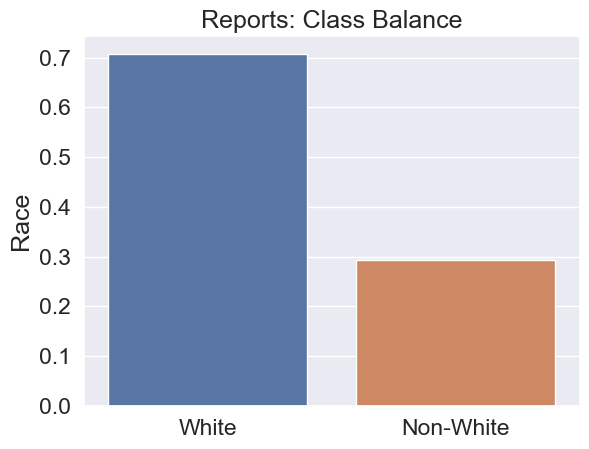

In [4]:
y = df['Race'].value_counts() / len(df)

sns.set(font_scale=1.5)
sns.barplot(x=y.index, y=y).set_title('Reports: Class Balance')
plt.show()

In [5]:
# Word Count

df['Word_Count'] = df['Report'].apply(lambda x: len(str(x).split()))
print(df[df['Race']=='White']['Word_Count'].mean()) 
print(df[df['Race']=='Non-White']['Word_Count'].mean())

433.0155555555556
480.8763440860215


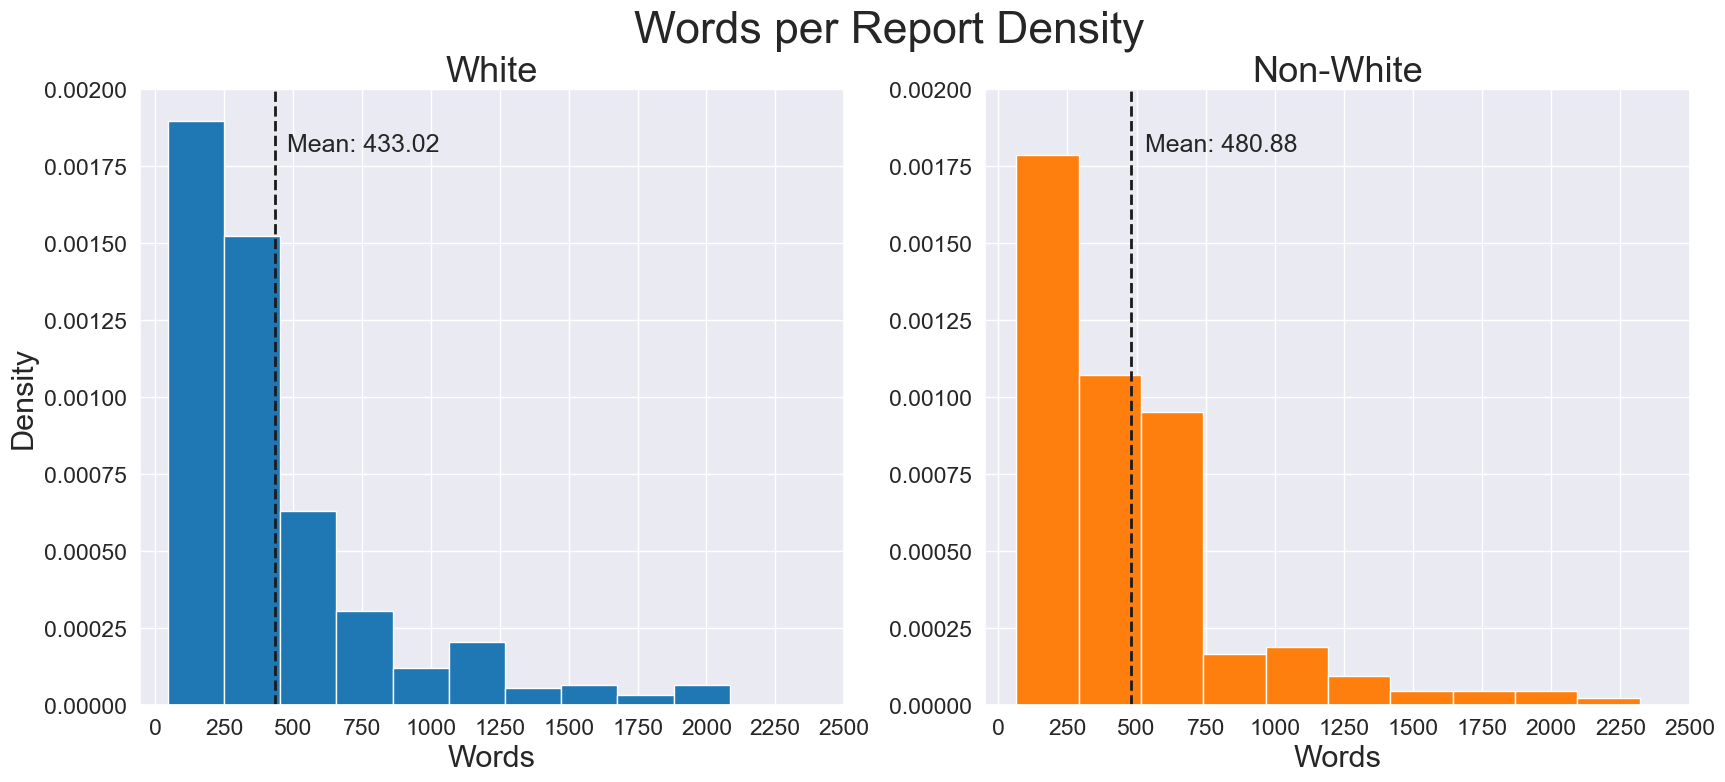

In [6]:
# Plotting Word Count

fig, axs = plt.subplots(1, 2, figsize=(20,8))

yticks = np.arange(0, 0.0021, 0.00025)
xticks = range(0, 2501, 250)

min_ylim, max_ylim = 0, 0.0020

ax = axs[0]
words=df[df['Race']=='White']['Word_Count']
ax.hist(words, color='tab:blue', density=True)
ax.set_xticks(xticks)
ax.set_xlabel('Words', fontsize=22)
ax.set_yticks(yticks)
ax.set_ylabel('Density', fontsize=22)
ax.set_title('White', fontsize=26)

ax.axvline(words.mean(), color='k', linestyle='dashed', linewidth=2)
ax.text(words.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(words.mean()))


ax = axs[1]
words=df[df['Race']=='Non-White']['Word_Count']
ax.hist(words, color='tab:orange', density=True)
ax.set_xticks(xticks)
ax.set_xlabel('Words', fontsize=22)
ax.set_yticks(yticks)
ax.set_title('Non-White', fontsize=26)

ax.axvline(words.mean(), color='k', linestyle='dashed', linewidth=2)
ax.text(words.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(words.mean()))

fig.suptitle('Words per Report Density', fontsize=32)
plt.show()

In [7]:
# Training Data

X_train = df['Report_Cleaned']
y_train = np.asarray(df['Race'].map({'White' : 0, 'Non-White' : 1}))

vectorizer = TfidfVectorizer(use_idf=True)
X_train = vectorizer.fit_transform(X_train)

print(X_train.shape)
print(y_train.shape)

(636, 6241)
(636,)


## Logistic Regression

In [12]:
# Logistic Regression

grid = {'C' : np.arange(1, 16, 1), 
        'penalty' : ['l1', 'l2'],
        'solver' : ['liblinear', 'saga'],
        'max_iter' : [100000]} 

classifier = LogisticRegression()
classifier_cv = GridSearchCV(classifier, grid, cv=10, scoring='f1_micro')
classifier_cv.fit(X_train,y_train)

print('Tuned Hyperparameters: ',  classifier_cv.best_params_)
print('F1 :', classifier_cv.best_score_)

Tuned Hyperparameters:  {'C': 5, 'max_iter': 100000, 'penalty': 'l1', 'solver': 'liblinear'}
F1 : 0.7295634920634921


In [15]:
classifier = LogisticRegression(C=5, max_iter=100000, penalty='l1', solver='liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(C=5, max_iter=100000, penalty='l1', solver='liblinear')

In [46]:
# Save our dataframe
checkpoint = '__checkpoints'
filename = 'reports-coeff_logreg.csv'

# important_tokens = pd.DataFrame(data=classifier.coef_[0], index=vectorizer.get_feature_names_out(), columns=['Coefficient']).reset_index().rename(columns={'index':'Word'}).reset_index().rename(columns={'index':'Index'})
# important_tokens = important_tokens.sort_values('Coefficient', ascending=False).reset_index(drop=True)
# important_tokens.to_csv(os.path.join(checkpoint, filename), index=False)

In [100]:
# Load our dataframe
checkpoint = '__checkpoints'
filename = 'reports-coeff_logreg.csv'

important_tokens = pd.read_csv(os.path.join(checkpoint, filename))
important_tokens.head(5)

,Index,Word,Coefficient
0,1665,dual,10.669721
1,3305,make,7.079204
2,1890,excellent,7.010839
3,2176,frame,6.755676
4,4728,runner,6.702583


In [101]:
matrix = X_train.todense()

for index, row in important_tokens.iterrows():
    if index == 0:
        train_df = pd.DataFrame(X_train.todense()[:, row['Index']], columns=[important_tokens[important_tokens['Index'] == row['Index']]['Word'].reset_index(drop=True)[0]])
    else:
        train_df = pd.concat([train_df, pd.DataFrame(X_train.todense()[:, row['Index']], columns=[important_tokens[important_tokens['Index'] == row['Index']]['Word'].reset_index(drop=True)[0]])], axis=1)
        
train_df.shape

(636, 92)

In [102]:
model = sm.Logit(y_train, train_df).fit(maxiter=100000)

Optimization terminated successfully.
         Current function value: 0.294111
         Iterations 11


In [104]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  636
Model:                          Logit   Df Residuals:                      544
Method:                           MLE   Df Model:                           91
Date:                Fri, 03 Feb 2023   Pseudo R-squ.:                  0.5133
Time:                        11:13:27   Log-Likelihood:                -187.05
converged:                       True   LL-Null:                       -384.36
Covariance Type:            nonrobust   LLR p-value:                 2.026e-39
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
dual               31.7564      9.905      3.206      0.001      12.342      51.171
make               10.5772      4.588      2.305      0.021       1.585      19.570
excellent          15.9230      

In [143]:
# Save our Model
checkpoint = '__checkpoints'
filename = 'reports-logit_model'

model.save(os.path.join(checkpoint, filename))

In [ ]:
# Load our Model
checkpoint = '__checkpoints'
filename = 'reports-logit_model'

model.load(os.path.join(checkpoint, filename))

In [153]:
# Define function to output plot of the model coefficients

def coefplot(results, figsize=(15, 10), sign=False, title='Coefficients of Features w/ 95% Confidence Intervals'):

    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])
    
    # Only Significat Features
    if sign:
        coef_df = coef_df[coef_df['P>|z|'].astype(float) < 0.05]

    ### Plot Coefficients ###

    # Labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster' will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', 
                 kind='bar', ax=ax, 
                 color='none', fontsize=22, 
                 ecolor='steelblue', capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title(title, fontsize=36)
    ax.set_ylabel('Coefficients', fontsize=24)
    ax.set_xlabel('Words', fontsize=24)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', 
               s=80, 
               y=coef_df['coef'], 
               color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

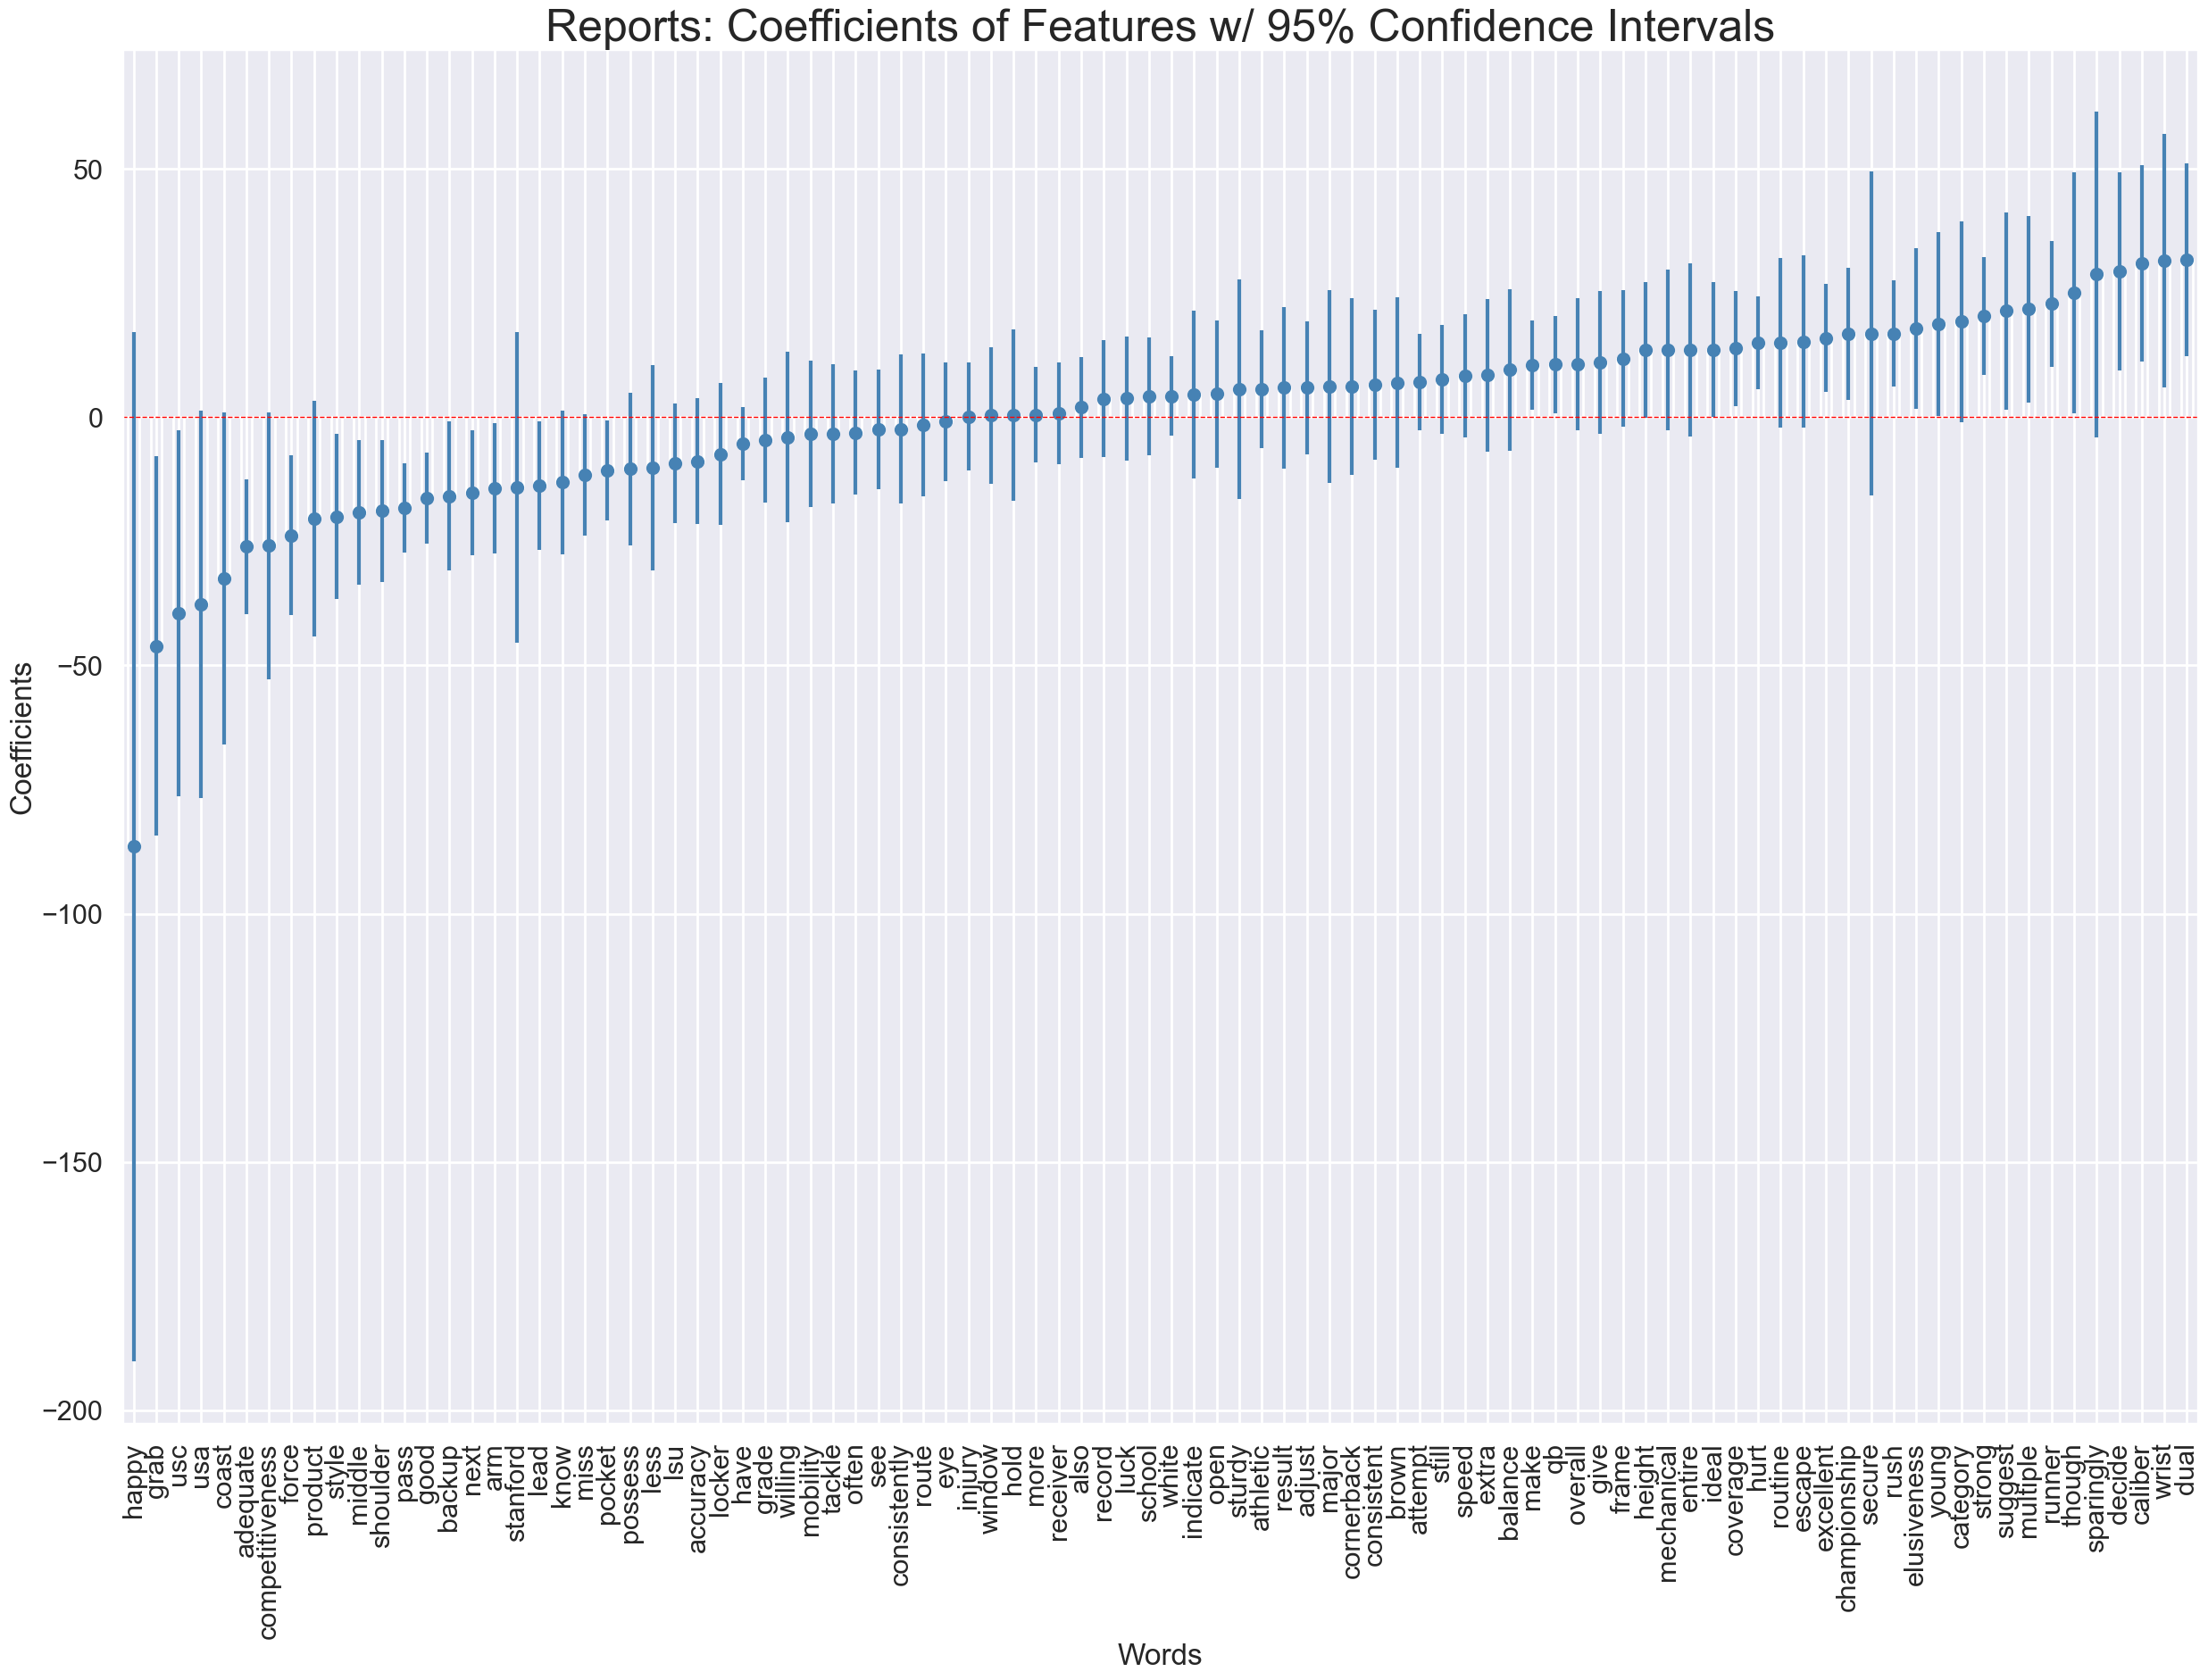

In [154]:
coefplot(model, (30, 20), title='Reports: Coefficients of Features w/ 95% Confidence Intervals')

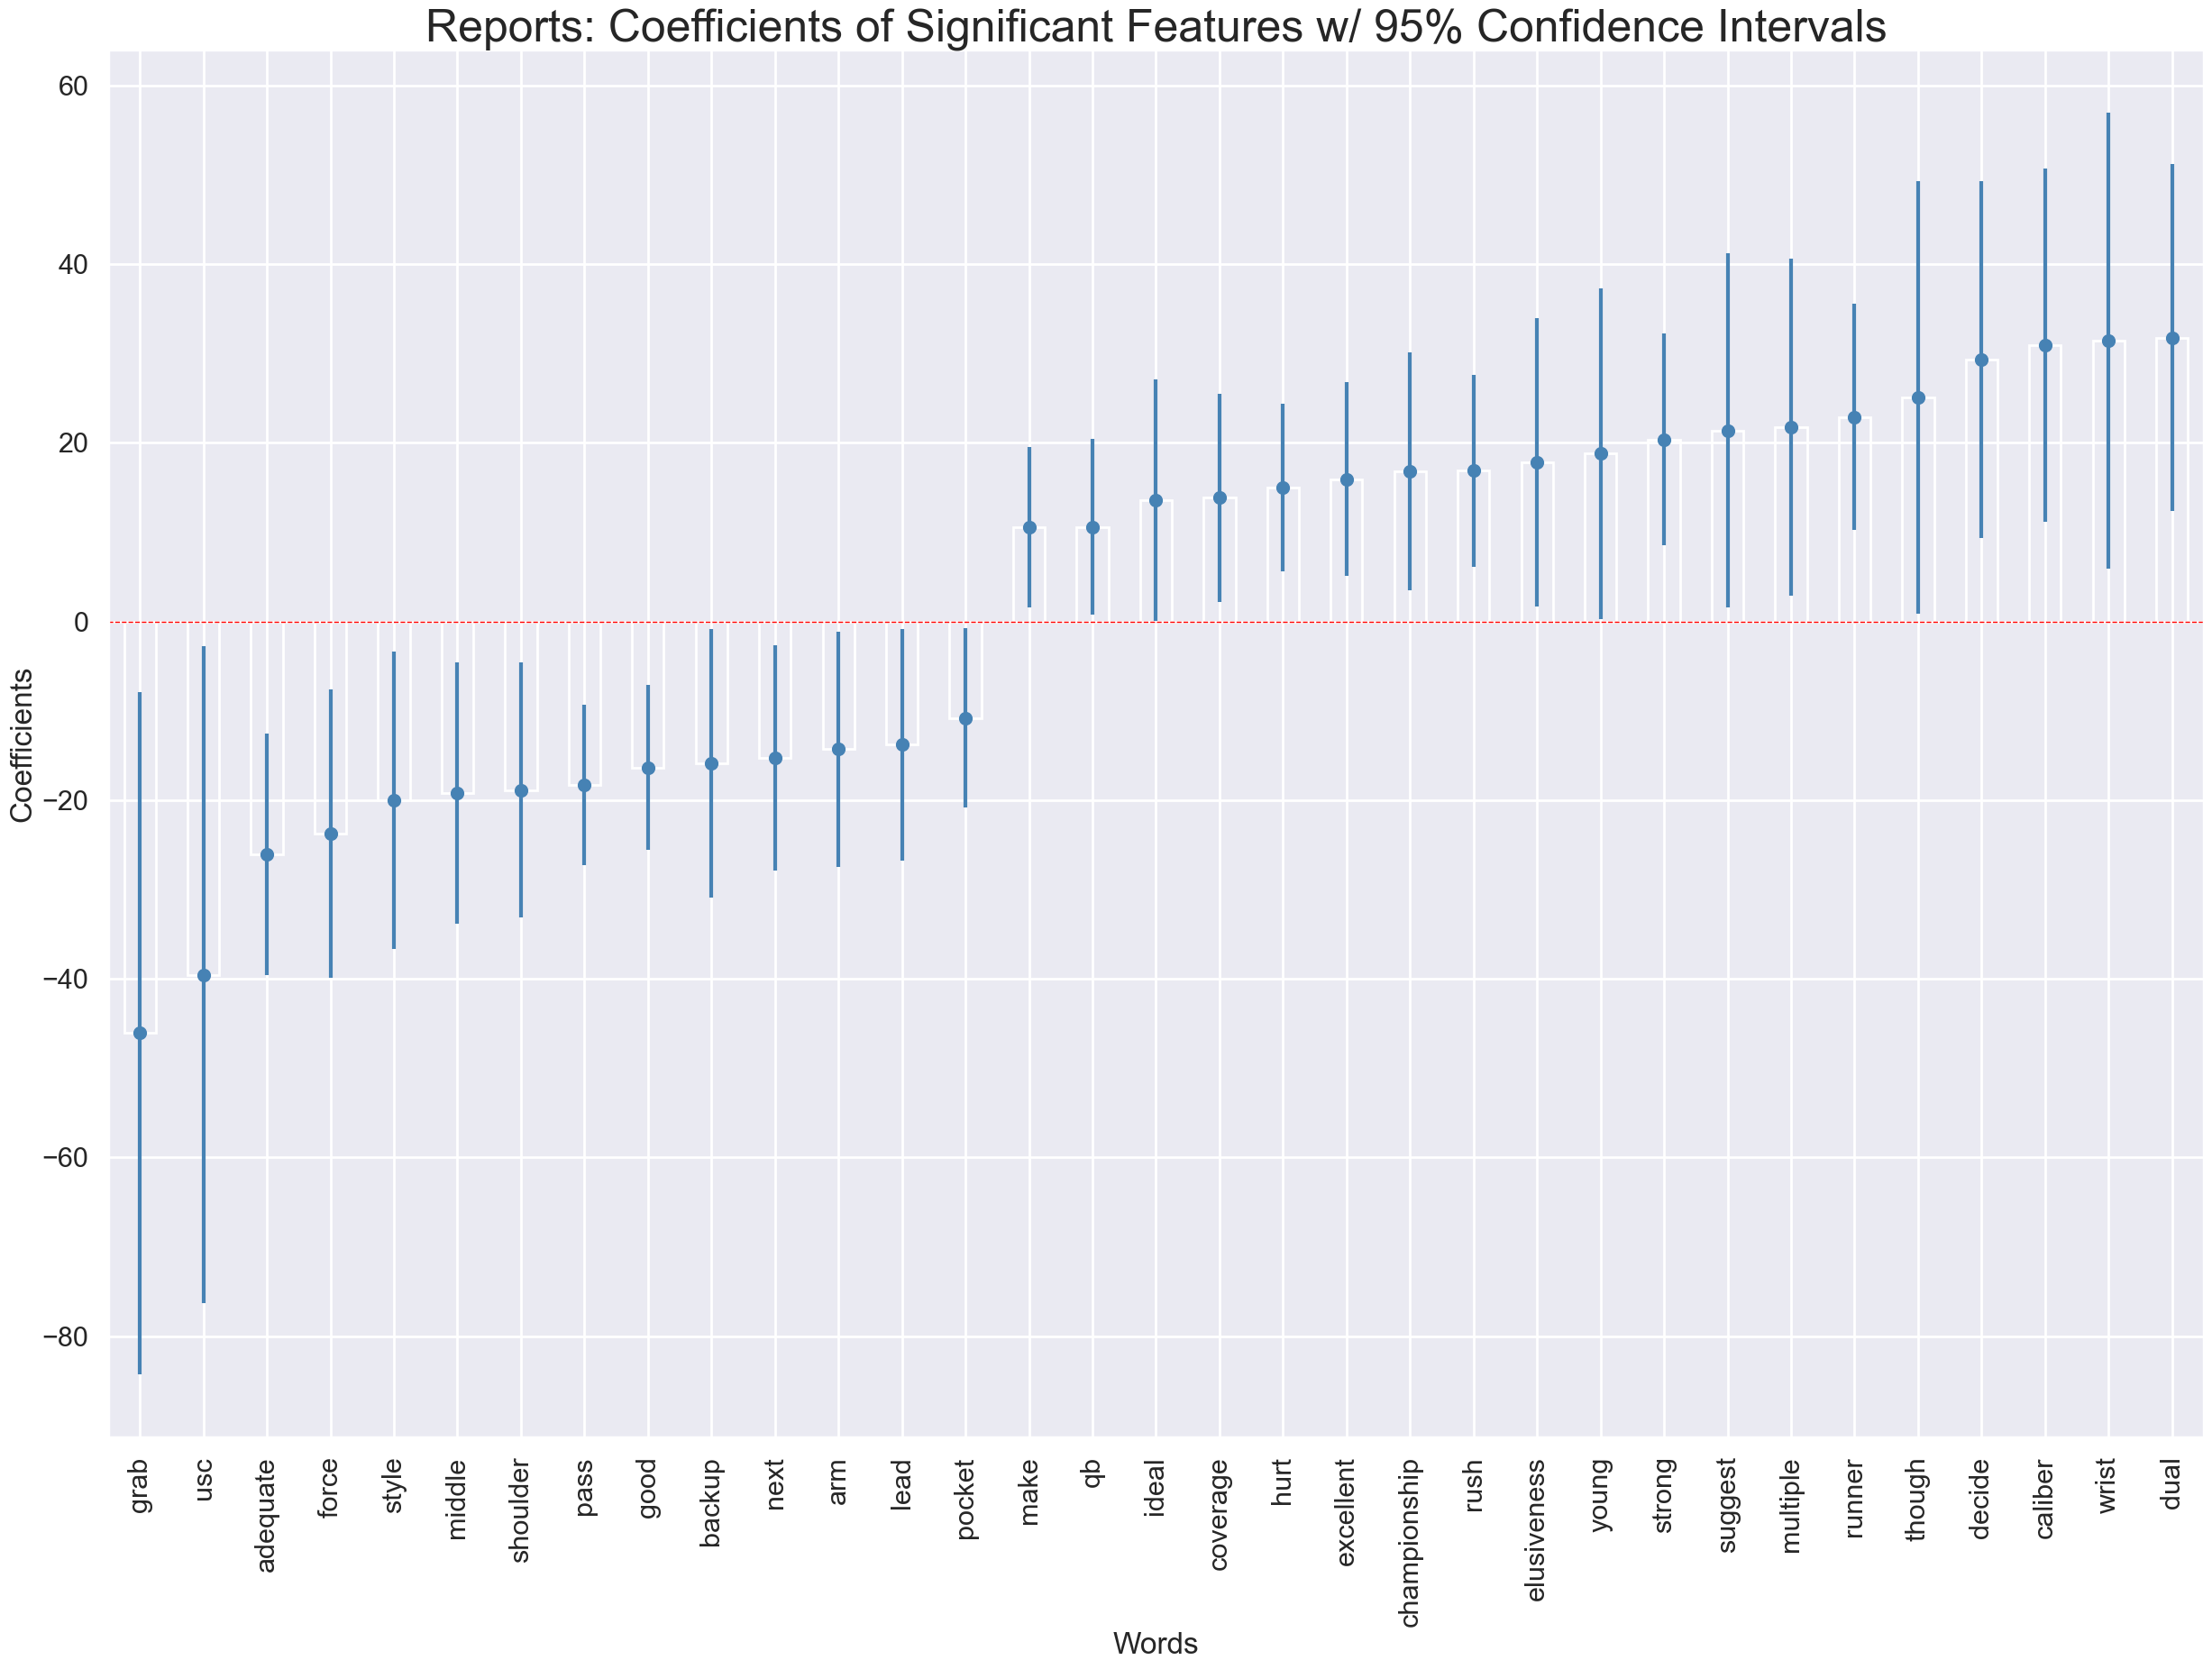

In [155]:
coefplot(model, (30, 20), sign=True, title='Reports: Coefficients of Significant Features w/ 95% Confidence Intervals')

In [159]:
coef_df = pd.DataFrame(model.summary().tables[1].data)
coef_df = coef_df.rename(columns=coef_df.iloc[0]).drop(0, axis=0).reset_index(drop=True)
coef_df

,,coef,std err,z,P>|z|,[0.025,0.975]
0,dual,31.7564,9.905,3.206,0.001,12.342,51.171
1,make,10.5772,4.588,2.305,0.021,1.585,19.570
2,excellent,15.9230,5.541,2.874,0.004,5.062,26.784
3,frame,11.7845,7.024,1.678,0.093,-1.983,25.552
4,runner,22.8928,6.469,3.539,0.000,10.215,35.571
...,...,...,...,...,...,...,...
87,adequate,-26.0523,6.904,-3.773,0.000,-39.584,-12.520
88,shoulder,-18.8548,7.302,-2.582,0.010,-33.167,-4.543
89,middle,-19.2075,7.444,-2.580,0.010,-33.798,-4.617
90,good,-16.3393,4.700,-3.476,0.001,-25.551,-7.127


In [157]:
coef_df['coef'] = coef_df['coef'].astype(float) 
coef_df[coef_df['P>|z|'].astype(float) < 0.05].sort_values('coef', ascending=False)

,,coef,std err,z,P>|z|,[0.025,0.975]
0,dual,31.75640,9.905,3.206,0.001,12.342,51.171
14,wrist,31.48010,13.016,2.419,0.016,5.969,56.991
13,caliber,30.94520,10.095,3.065,0.002,11.159,50.731
12,decide,29.31240,10.189,2.877,0.004,9.342,49.282
31,though,25.07720,12.347,2.031,0.042,0.878,49.277
4,runner,22.89280,6.469,3.539,0.000,10.215,35.571
52,multiple,21.77010,9.607,2.266,0.023,2.940,40.600
37,suggest,21.38460,10.120,2.113,0.035,1.550,41.219
5,strong,20.37020,6.058,3.363,0.001,8.497,32.243
7,young,18.80230,9.451,1.990,0.047,0.280,37.325


## Random Forest

In [8]:
# Random Forest
grid = {'criterion' : ['gini', 'entropy', 'log_loss'],
        'max_depth': [50, 100, None],
        'max_features': ['sqrt'],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 500, 1000, 1500, 2000]}

classifier = RandomForestClassifier()
classifier_cv = GridSearchCV(classifier, grid, cv=10, scoring='f1_micro')
classifier_cv.fit(X_train, y_train)

print('Tuned Hyperparameters: ',  classifier_cv.best_params_)
print('F1 :', classifier_cv.best_score_)

In [ ]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

In [ ]:
# Save our dataframe
checkpoint = '__checkpoints'
filename = 'reports-coeff_randfor.csv'

In [ ]:
# Load our dataframe
checkpoint = '__checkpoints'
filename = 'reports-coeff_randfor'

important_tokens = pd.read_csv(os.path.join(checkpoint, filename))

In [ ]:
features = vectorizer.get_feature_names()
fi = classifier.feature_importances_
importance = [(features[i], fi[i]) for i in range(len(features))]

important_tokens = pd.DataFrame(importance)
important_tokens.columns = ['Feature', 'Importance']